# Identifying the Drivers of Churn at Telco
***
***
# Goals
***

My goals for this project are as follows
- Create a model that will acurrately predict customer churn using the customer data provided
- Deliver a presentation that summarizes this project

A link to the presentation slides can be found below.

https://docs.google.com/presentation/d/1fI64dzhV6jX33lD-tAv9IEc0MOXx1_ilWL54OKl9aRQ/edit?usp=sharing

# Setup
***

In [3]:
# preparing environment
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

#import acquire as ac
from acquire import get_telco_data
from prepare import prepare_telco

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score


# Acquire
Acquire data from the customers table from the telco_churn database on the codeup data science database server.
***

In [4]:
# display data frame
df = get_telco_data()

df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes


# Prepare
Prepare, tidy, and clean the data so it can be explored and analyzed
***

### Checking column names, data types, and null counts

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

- Categorical object variables such as gender, churn and dependents may need to be converted to 0s and 1s
- No missing values
    - Values with only white space may exist however
- Rename tenure to reflect unit of measurement
- Convert total_charges to float

In [5]:
# displaying unique values per column to identify categorical variables
for col in df:
    if col != 'customer_id' and col != 'total_charges' and col != 'monthly_charges' and col != 'tenure':
        print(df[col].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: senior_citizen, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
No                     2810
Yes                    2707
No in

- convert columns with 2 values to 0s and 1s
- "no x service" values can be converted to "No" (soon to be 0)

### Preparing data with changes outlined in "prepare takeaways" section below using prepare_teclo function from prepare.py

In [7]:
train, validate, test = prepare_telco(df)

### Prepare Takeaways

- converted object columns with binary values to 0s and 1s
- renamed gender column to female (female = 1)
- renamed tenure to tenure_months
- added column for tenure years
- removed duplicates
- converted total_charges to float
- no null values found
- 11 white space values in total_charges filed with 0 since client has not been charged yet
- split into train, validate, test

# Explore
I'll begin exploring the prepped data to identify drivers of churn and relationships between variables.
***

In [6]:
# displaying various values for numerical columns (average, quartiles, min, max, etc)
# this allows us to get a rough idea of the values within the columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


- Senior_citizen: seniors are a minority
- Tenure: 72 month max means there are no records older than 6 years
- Type_ids for internet_service, contract, and paymenta are already numerical so no need to convert
- Monthly_charges: the average monthly payment is 64.76

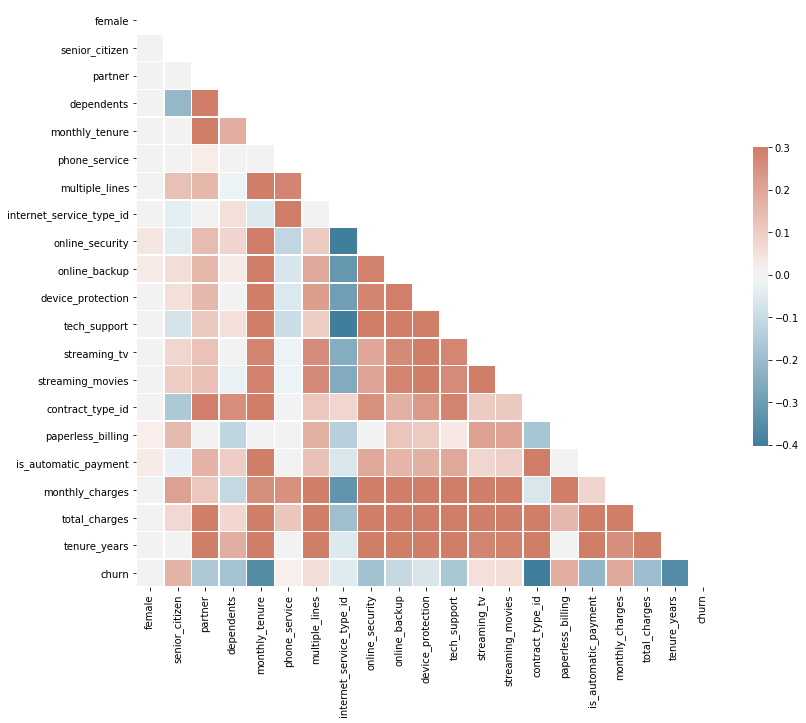

In [8]:
# creating a heatmap that will show the correlation of the variables to one another
# specifically, I'm interested in the correlation between churn and each other variable
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

These variables show strong connections to churn but I won't explore them for various reasons
- contract_type_id
    - Can't change per project specifications
- monthly_tenure / tenure_years
    - Increase as churn lowers but we can only influence it by convincing clients to stay via other variables
- total_charges
    - Builds up over time the longer a customer has been with us. Not something we can control directly.
    
The variables that I'll be exploring further because they appear to have strong correlations with churn are
- senior citizen
- partner
- dependents
- paperless_billing
- is_automatic_payment
- monthly_charges

## Exploring Individual Variables
Note: For all hypothesis tests, all assumptions were met. In cases of differing variance, the equal_var argument was set to "false".
***

## Variable: Monthly_Charges
Clients may be cost sensitive and as a result, they may be leaving Telco in order to save money by paying less to a competitor.

### Monthly_charge (Plot)

Plotting to see if a majority of clients who have churned have also had high monthly charges. 

Text(0.5, 1.0, 'Non-Churned Clients')

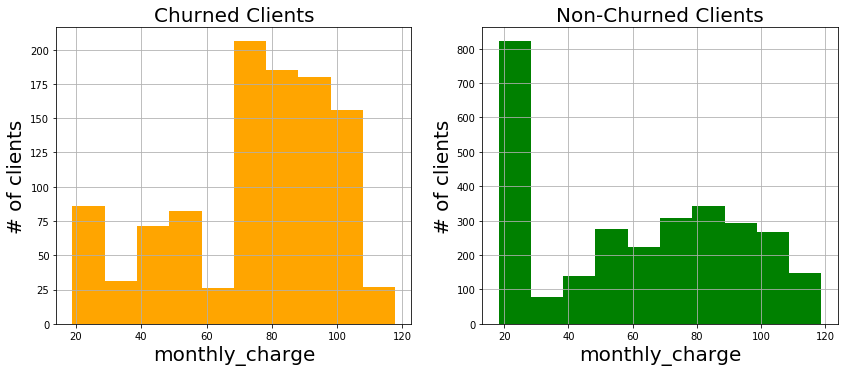

In [9]:
# setting figure size
plt.figure(figsize=(14,12))

# plotting churned customer monthly charges data
plt.subplot(221)
churn_vs_monthly_charges = train[train.churn == 1].monthly_charges
churn_vs_monthly_charges.hist(color='orange')
plt.xlabel('monthly_charge', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Churned Clients', fontsize = 20)

# plotting non-churned customer monthly charges data
plt.subplot(222)
churn_vs_monthly_charges = train[train.churn == 0].monthly_charges
churn_vs_monthly_charges.hist(color = 'green')
plt.xlabel('monthly_charge', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Non-Churned Clients', fontsize = 20)

- It appears that clients who have churned payed more per month that clients who have not churned.

### Monthly_charge (Hypothesis Test)
Running a one-tailed, two-sample t-test to further explore this variable.

__Idea:__ I believe churned clients have had higher monthly charges on average than clients who have not churned
<br>
__H0:__ Churned customer average monthly_charges <=  Non-Churned customer average monthly_charges
<br>
__Ha:__ Churned customer average monthly_charges >  Non-Churned customer average monthly_charges

In [14]:
# Running a one-tailed, two-sample t-test

# setting alpha
test_1_alpha = .05

# creating DFs for churned and non-churned monthly charges
churn_monthly_charge = train[(train.churn == 1)].monthly_charges
no_churn_monthly_charge = train[(train.churn == 0)].monthly_charges

# running test
t_1, p_1 = stats.ttest_ind(churn_monthly_charge, no_churn_monthly_charge, equal_var = False)

# printing results
print('t = ',t_1,'\n')
print('p = ',p_1/2,'\n')

if p_1/2 > test_1_alpha:
    print('We fail to reject H0, there is no difference in monthly charges between churned and non-churned clients')
elif t_1 < 0:
    print('We fail to reject H0, there is no difference in monthly charges between churned and non-churned clients')
else:
    print('t > 0 and p < alpha so I reject the null hypothesis.\n')
    print('The sign of the t value (negative or positive) matters since this is a "greater than" test.')

t =  13.714038979262032 

p =  1.6002099781261748e-41 

t > 0 and p < alpha so I reject the null hypothesis.

The sign of the t value (negative or positive) matters since this is a "greater than" test


###  Monthly Charges Takeaways
- Plot showed that churned clients were paying more per month than non-churned customers on average.
    - Hypothesis test reinforced this finding
- This could mean that many of our customers are price sensitive and as a result, high monthly charges were at least a moderate factor in the decision to leave.

## Variable: Partner
Partners being on an account together can create an exit barrier for clients because they prefer to be on an account with their partner and don't want to have to both go through the process of signing up for a new service. 
***

### Partner (Plot)

Plotting to see if clients who have a partner on their account are retained longer than clients without partners.

Text(0.5, 1.0, 'Clients w/o Partner')

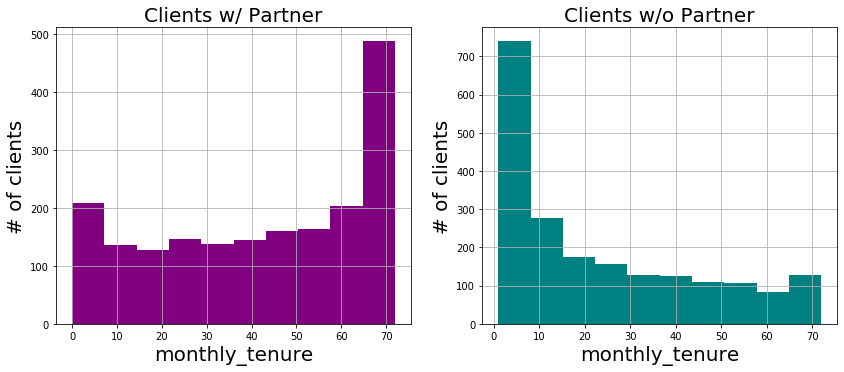

In [11]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/partner monthly tenure
plt.subplot(221)
partner_tenure = (train[train.partner == 1].monthly_tenure)
partner_tenure.hist(color = 'purple')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Partner', fontsize = 20)

# creating plot of clients w/partner monthly tenure
plt.subplot(222)
no_partner_tenure = (train[train.partner == 0].monthly_tenure)
no_partner_tenure.hist(color = 'teal')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/o Partner', fontsize = 20)

Plot takeaway: Clients with partners on their accounts seem to have higher monthly tenure than clients without partners.

### Partner (Hypothesis Test)
Running a one-tailed, two-sample t-test to further explore this variable.

__Idea:__ Clients with partners stay with us longer than those without partners.
<br>
__H0:__ Average monthly tenure of clients with partners <= monthly tenure of clients without partners
<br>
__Ha:__ Average monthly tenure of clients with partners > monthly tenure of clients without partners

In [13]:
# Running a one-tailed, two-sample t-test 

# setting alpha
test_2_alpha = .05

# creating DFs for monthly tenure of clients with and without partners
partner_tenure = train[(train.partner == 1)].monthly_tenure
nopartner_tenure = train[(train.partner == 0)].monthly_tenure

# running t-test
t_2, p_2 = stats.ttest_ind(partner_tenure, nopartner_tenure, equal_var = False)


# printing results
print('t = ',t_2,'\n')
print('p = ',p_2/2,'\n')

if p_2/2 > test_2_alpha:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with partners and those without')
elif t_2 < 0:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with partners and those without')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.\n')
    print('The sign of the t value (negative or positive) matters since this is a "greater than" test')

t =  26.69141466582996 

p =  1.7388736395136545e-144 

t > 0 and p < alpha so we reject the null hypothesis.

The sign of the t value (negative or positive) matters since this is a "greater than" test


### Partner Takeaways
- Plots showed that clients with partners have longer monthly tenures than those without partners.
    - Hypothesis tests gave further evidence of this
- This could mean that customers are motivated to stay with Telco when their partner is on their account because they'd prefer to avoid the process of switching over both of their services a different provider.

## Variable: Dependents
Just as having a partner on an account can create an exit barrier for a customer, the same can hold true for dependents. Some clients may prefer to remain with Telco in order to avoid having to switch all of their depedents along with themselves to a new service.
***

### Depedents (plot)
Plotting to see if clients who have a partner on their account stay with Telco longer than clients without partners.

Text(0.5, 1.0, 'Clients w/o dependent')

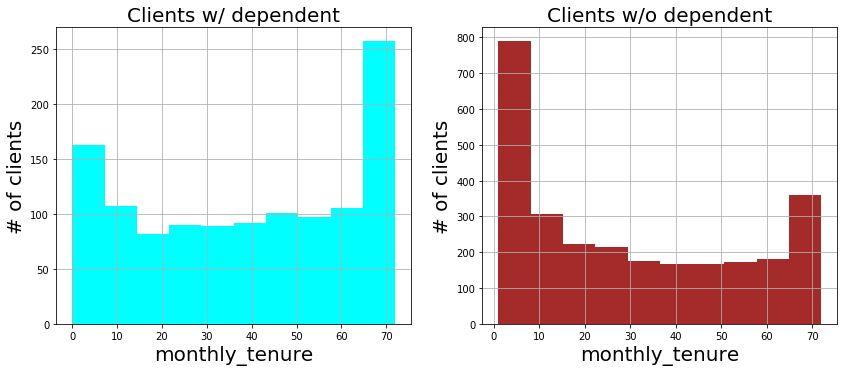

In [13]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/dependents monthly tenure
plt.subplot(221)
dependent_tenure = (train[train.dependents == 1].monthly_tenure)
dependent_tenure.hist(color = 'cyan')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ dependent', fontsize = 20)

# creating plot of clients w/dependents monthly tenure
plt.subplot(222)
no_dependent_tenure = (train[train.dependents == 0].monthly_tenure)
no_dependent_tenure.hist(color = 'brown')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/o dependent', fontsize = 20)

Plot takeaway: Clients with dependents on their accounts seem to have higher monthly tenure than clients without dependents.

### Dependent (Hypothesis Test)
Running a one-tailed, two-sample t-test to further explore this variable.

__Idea__: Clients with dependents stay with Telco longer than those without dependents.
<br>
__H0__: Monthly tenure of clients with dependents <= monthly tenure of clients without dependents
<br>
__Ha__: Monthly tenure of clients with dependents > monthly tenure of clients without dependents

In [15]:
# Running a one-tailed, two-sample t-test

# setting alpha
test_3_alpha = .05

# creating DFs for monthly tenure of clients with and without dependents
dependent_tenure = train[(train.dependents == 1)].monthly_tenure
nodependent_tenure = train[(train.dependents == 0)].monthly_tenure

# running t-test
t_3, p_3 = stats.ttest_ind(dependent_tenure, nodependent_tenure, equal_var = False)


# printing results
print('t = ',t_3,'\n')
print('p = ',p_3/2,'\n')

if p_3/2 > test_3_alpha:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with dependents and those without')
elif t_3 < 0:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with dependents and those without')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.\n')
    print('The sign of the t value (negative or positive) matters since this is a "greater than" test')

t =  11.308630261450755 

p =  3.517064650495694e-29 

t > 0 and p < alpha so we reject the null hypothesis.

The sign of the t value (negative or positive) matters since this is a "greater than" test


### Dependents Takeaways
- Plots showed that clients with dependents have longer monthly tenures than those without dependents.
    - Hypothesis gave further evidence of this
- This suggests Telco's customers are motivated to stay when a dependent is on their account because they'd prefer to avoid the process of switching their services to a different provider.

## Varialbe: Automatic_payment
***
Convenience is a major selling point for many consumers. The value that clients glean from using automatic payment methods may play a significant role in Telco's ability to retain them.

### Automatic_payment (plot)
Plotting to see if clients who use automatic payments stay with Telco longer than clients who make payments manually.

Text(0.5, 1.0, 'Clients w/ Manual Payments')

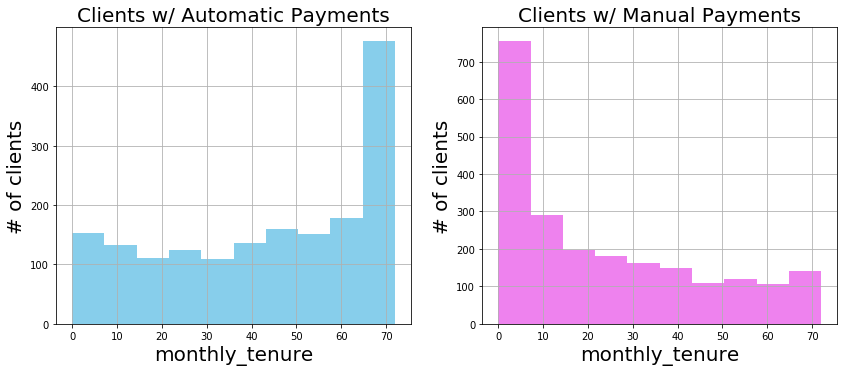

In [15]:
# setting figure size
plt.figure(figsize=(14,12))

# creating plot of clients w/automatic payment monthly tenure
plt.subplot(221)
automatic_tenure = (train[train.is_automatic_payment == 1].monthly_tenure)
automatic_tenure.hist(color = 'skyblue')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Automatic Payments', fontsize = 20)

# creating plot of clients w/manual payment monthly tenure
plt.subplot(222)
manual_tenure = (train[train.is_automatic_payment == 0].monthly_tenure)
manual_tenure.hist(color = 'violet')
plt.xlabel('monthly_tenure', fontsize = 20)
plt.ylabel('# of clients', fontsize = 20)
plt.title('Clients w/ Manual Payments', fontsize = 20)

Plot takeaway: Clients with dependents on their accounts seem to have higher monthly tenure than clients without dependents.

### Automatic Payment (Hypothesis Test)
Running a two-sample one-tailed t-test to explore this variable further

__Idea:__ Clients who make payments automatically stay with us longer than those who make payments manually.
<br>
__H0:__ Monthly tenure of clients making automatic payments <= monthly tenure of clients making payments manually 
<br>
__Ha:__ Monthly tenure of clients making automatic payments > monthly tenure of clients making payments manually 

In [17]:
# Running a one-tailed, two-sample t-test

# setting alpha
alpha = .05

# creating DFs for monthly tenure of clients who make automatic and manual payments
automatic_tenure = train[(train.is_automatic_payment == 1)].monthly_tenure
manual_tenure = train[(train.is_automatic_payment  == 0)].monthly_tenure

# running t-test
t_4, p_4 = stats.ttest_ind(automatic_tenure, manual_tenure, equal_var = False)

# printing results
print('t = ',t_4,'\n')
print('p = ',p_4/2,'\n')

if p_4/2 > alpha:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with automatic payments and those with manual.')
elif t_4 < 0:
    print('I fail to reject H0, there is no difference in monthly tenure between clients with automatic payments and those with manual.')
else:
    print('t > 0 and p < alpha so we reject the null hypothesis.\n')
    print('The sign of the t value (negative or positive) matters since this is a "greater than" test')

t =  27.876885462659963 

p =  2.1306049814062135e-155 

t > 0 and p < alpha so we reject the null hypothesis.

The sign of the t value (negative or positive) matters since this is a "greater than" test


### Automatic Payment Takeaways
- Plots showed that clients who make payments automatically have longer monthly tenures than those who do so manually.
    -  Hypothesis test provided further evidence of this
- It's possible that our customers appreciate the convenience of automatic payments and find value in it.

## Variable: Senior_Citizen

### Senior Citizen (Hypothesis Test)
Running a two-sample two-tailed t-test to explore this variable further

__Idea:__ Are seniors leaving Telco sooner or later than non-seniors on average?
<br>
__H0:__ Monthly tenure of seniors = Monthly tenure of non seniors
<br>
__Ha:__ Monthly tenure of seniors != Monthly tenure of non seniors

In [18]:
# creating DFs for seniors and non-seniors
senior_tenure = train[(train.senior_citizen == 1)].monthly_tenure
nonsenior_tenure = train[(train.senior_citizen == 0)].monthly_tenure

# performing two-tailed, two-sample t-test
t, p = stats.ttest_ind(senior_tenure, nonsenior_tenure, equal_var = False)

# printing results
print('alpha = .05')
print(f'p: {p}')

print('\nSince p > alpha (.05), I fail to reject the null hypothesis.')

alpha = .05
p: 0.38648052790561027

Since p > alpha (.05), I fail to reject the null hypothesis.


- Hypothesis test shows there is no difference in monthly tenure between seniors and non-seniors. 
- Given this, I won't explore senior status further as a driver of churn.

## Variable: Paperless Billing

### Paperless Billing (Hypothesis Test)
Running a two-sample two-tailed t-test to explore this variable further

__Idea:__ Are paperless billing customers leaving leaving us sooner or later than non-paperless billing customers on average?
<br>
__H0:__ Monthly tenure of paperless billing customers = Monthly tenure of non-paperless billing customers
<br>
__Ha:__ Monthly tenure of paperless billing customers != Monthly tenure of non-paperless billing customers

In [39]:
# creating DFs for customers with paperless billing and without paperless billing
paperless_tenure = train[(train.paperless_billing == 1)].monthly_tenure
nopaperless_tenure = train[(train.paperless_billing == 0)].monthly_tenure

# performing two-sample two-tailed t-test
t, p = stats.ttest_ind(paperless_tenure, nopaperless_tenure, equal_var = False)

# printing results
print('alpha = .05')
print(f'p: {p}')

print('\nSince p > alpha (.05), I fail to reject the null hypothesis. The monthly tenure of paperless billing customers is no different than the monthly tenure of non-paperless billing customers.')

alpha = .05
p: 0.5605403707371726

Since p > alpha (.05), I fail to reject the null hypothesis. The monthly tenure of paperless billing customers is no different than the monthly tenure of non-paperless billing customers.


- Hypothesis test shows there is no difference in monthly tenure between paperless billing and non-paperless billing customers
- Given this, I won't explore paperless billing further as a driver of churn.

## Overall Exploration Takeaways

- These variables were explored but were found to have weak or little connection to churn
    * senior_citizen
    * paperless_billing
<br>
<br>
- These variables show strong connections to churn but I did not explore them further for various reasons
    * contract_type_id 
        * Can't change per project specifications
    * monthly_tenure / tenure_years 
        * Increases as churn lowers but we can only influence it by convincing clients to stay via other      variables
    * total_charges
        * Builds up over time the longer a customer has been with us. Not something we can control directly.
<br>
<br>
- Via plotting and hypothesis testing I found evidence that suggests the following:
    - Clients who have churned had larger monthly charges than those who have not churned
    - Clients with partners stay with Telco longer than those without
    - Clients with dependents stay with Telco longer than those without
    - Clients who make automatic payments stay with Telco longer than those who make payments manually
<br>
<br>
- These findings suggest that the following are drivers of churn:
    - Large monthly charges (monthly_charges)
    - No partner on account (partner)
    - No dependents on account (dependents)
    - Making payments manually (is_payment_automatic)

# Modeling
I will use the variables that I have found to be related to churn to create a model that will predict if a customer will churn.
***

## Baseline
Constructing a baseline and gauge its accuracy to determine what accuracy an alternate model would need in order to be viable.
***

In [19]:
# copying train DF since I'm going to add a new column and I don't want to alter the train table yet
train_bl = train

# adding "baseline_prediction column" that predicts no one will churn since not churning (0), is the most common value
train_bl['baseline_prediction'] = 0

train_bl.head()

,customer_id,female,senior_citizen,partner,dependents,monthly_tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_tv,streaming_movies,contract_type_id,paperless_billing,is_automatic_payment,monthly_charges,total_charges,tenure_years,churn,baseline_prediction
4604,6490-FGZAT,0,0,0,0,6,1,0,3,0,...,0,0,1,0,0,20.65,109.30,0.5,0,0
5566,7841-FCRQD,1,0,1,0,33,1,0,1,0,...,0,0,2,1,1,53.75,1857.30,2.8,0,0
6204,8777-MBMTS,1,1,1,0,65,1,0,2,0,...,1,1,3,1,1,105.85,6725.50,5.4,0,0
5837,8212-CRQXP,1,0,1,0,22,1,0,2,0,...,1,0,1,1,1,80.00,1706.45,1.8,0,0
1276,1897-OKVMW,1,0,1,1,64,1,1,1,1,...,1,1,3,1,0,90.60,5817.45,5.3,0,0


In [20]:
# calculating accuracy of baseline model
baseline_accuracy = (train_bl['baseline_prediction'] == train_bl['churn']).mean()

print('Accuracy of baseline model is',round(baseline_accuracy,2)*100,'%')

Accuracy of baseline model is 73.0 %


### Baseline Takeaways
- Since I'm prioritizing the detection of false positives, false negatives, true positives, or true negatives and our main goal is to build a model that accurately predicts whether a customer will churn or not, I will be focusing on accuracy.
- The baseline model's accuracy of 73% is the metric that our alternate models will need to surpass.

## Modeling (Training)
In this phase I will create 3 models that will attempt to predict which customers churn in the train data set. Any models that surpass the baseline model's accuracy (73%) will be taken to the next phase, validation.
***

## Model 1

__Name__: Model 1
<br>
<br>
__Type__: K-Nearest Neighbor
<br>
<br>
__Features__:
- is_automatic_payment
- dependents
- partner
- monthly_charges
<br>

__Hyper Parameters__:
- n_neighbors = 3
- weights = 'uniform'

In [21]:
# creating logistic regression object
knn = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')

# creating DF with selected features for logistic regression model
m1_X_train = train[['is_automatic_payment','dependents','partner','monthly_charges']]
m1_y_train = train['churn']

# fitting model to data
knn.fit(m1_X_train, m1_y_train)

# making predictions on x train
m1_y_pred = pd.DataFrame(knn.predict(m1_X_train))

# previewing predictions of model
m1_y_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [22]:
print(classification_report(m1_y_train, m1_y_pred))

print("Model 1's accuracy is 80%.\n")
print('Baseline models accuracy surpassed by a fair margin (7%). This model will move to validation')

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2893
           1       0.68      0.51      0.58      1050

    accuracy                           0.80      3943
   macro avg       0.76      0.71      0.73      3943
weighted avg       0.79      0.80      0.80      3943

Model 1's accuracy is 80%.

Baseline models accuracy surpassed by a fair margin (7%). This model will move to validation


## Model 2

__Name__: Model 2
<br>
<br>
__Type__: Decision Tree
<br>
<br>
__Features__:
- is_automatic_payment
- monthly_charges
<br>

__Hyper Parameters__:
- max depth = 2

In [23]:
# creating decision tree object
m2_dtree = DecisionTreeClassifier(max_depth = 3, random_state=123)

# creating DF with selected features for d tree
m2_X_train = train[['is_automatic_payment','monthly_charges']]
m2_y_train = train['churn']

# fitting d tree to data
m2_dtree.fit(m2_X_train, m2_y_train)

# making predictions about churn on train data
m2_y_pred = pd.DataFrame(m2_dtree.predict(m2_X_train))

# previewing predictions
m2_y_pred.head()

,0
0,0
1,0
2,0
3,0
4,1


In [24]:
print(classification_report(m2_y_train, m2_y_pred))

print("Model 2's accuracy is 73%.\n")
print("Baseline models accuracy matched. This model won't move to validation if our other model surpasses the baseline.")

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2893
           1       0.50      0.49      0.49      1050

    accuracy                           0.73      3943
   macro avg       0.66      0.66      0.66      3943
weighted avg       0.73      0.73      0.73      3943

Model 2's accuracy is 73%.

Baseline models accuracy matched. This model won't move to validation if our other model surpasses the baseline.


## Model 3

__Name__: Model 3
<br>
<br>
__Type__: Logistic Regression
<br>
<br>
__Features__:
- is_automatic_payment
- dependents
- partner
- monthly_charges
<br>


__Hyper Parameters__:
None

__Note__: Changed model type to Logistic Regression from Decision Tree

In [25]:
# creating logistic regression object
m3_logit = LogisticRegression(random_state=123)

# creating DF with selected features for logistic regression model
m3_X_train = train[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_train = train['churn']

# fitting model to data
m3_logit.fit(m3_X_train, m3_y_train)

# making predictions on train dataset
m3_y_pred = pd.DataFrame(m3_logit.predict(m3_X_train))

# previewing predictions of model
m3_y_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [26]:
print(classification_report(m3_y_train, m3_y_pred))

print('Model 3''s accuracy is 74%.\n')
print('Baseline models accuracy surpassed. This model may move to the validation.')

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2893
           1       0.52      0.19      0.28      1050

    accuracy                           0.74      3943
   macro avg       0.64      0.56      0.56      3943
weighted avg       0.70      0.74      0.69      3943

Model 3s accuracy is 74%.

Baseline models accuracy surpassed. This model may move to the validation.


### Modeling (Training) Takeaways
- Baseline model accuracy: 73%
<br>
- Model 1 accuracy (training): 80%
<br>
- Model 2 accuracy (training): 73%
<br>
- Model 3 accuracy (training): 74%
<br>
<br>
- Models 1 and 3 outperformed the baseline, they will be used in the validation phase to discern which is our overall best model.

## Modeling (Validation)
I will now be applying the most promising models, models 2 and 3 to the validation dataset. This will give me an idea of how the models perform on data they have not yet seen.
***

### Model 1 (K Nearest Neighbors)

In [27]:
# creating DF with selected features for logistic regression model
m1_X_validate = validate[['is_automatic_payment','dependents','partner','monthly_charges']]
m1_y_validate = validate['churn']

# making predictions on x validate
m1_y_pred_val = pd.DataFrame(knn.predict(m1_X_validate))

# previewing predictions of model
m1_y_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [40]:
print(classification_report(m1_y_validate, m1_y_pred_val))

print("Model 1's accuracy is 72%.\n")

print('The accuracy of this model has dropped ~10% from the training dataset results.')

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1249
           1       0.44      0.31      0.37       442

    accuracy                           0.72      1691
   macro avg       0.61      0.59      0.59      1691
weighted avg       0.69      0.72      0.70      1691

Model 1's accuracy is 72%.

The accuracy of this model has dropped ~10% from the training dataset results.


### Model 3

In [29]:
# creating DF with selected features for logistic regression model
m3_X_validate = validate[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_validate = validate['churn']

# making predictions on validate dataset
m3_y_pred_val = pd.DataFrame(m3_logit.predict(m3_X_validate))

# previewing predictions of model
m3_y_pred_val.head()

,0
0,0
1,0
2,0
3,0
4,0


In [30]:
print(classification_report(m3_y_validate, m3_y_pred_val))

print("Model 3's accuracy is 74%.\n")
print("This is our best model. It has outperformed every other model thus far. Its ready for use on the test data set.")

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1249
           1       0.51      0.22      0.31       442

    accuracy                           0.74      1691
   macro avg       0.64      0.57      0.58      1691
weighted avg       0.70      0.74      0.70      1691

Model 3's accuracy is 74%.

This is our best model. It has outperformed every other model thus far. Its ready for use on the test data set.


### Modeling (Validation) Takeaways

- Model 1 accuracy (validation): 71%
<br>
- Model 3 accuracy (validation): 74%
<br>
<br>
- Model 3 will be used on the test sample since it has the highest accuracy and is still outperforming the baseline model's accuracy.

## Test
The best model, model 3, will now applied to the test dataset. 
***

In [31]:
# creating DF with selected features for logistic regression model
m3_X_test = test[['is_automatic_payment','dependents','partner','monthly_charges']]
m3_y_test = test['churn']

# making predictions on test data set
m3_y_pred_test = pd.DataFrame(m3_logit.predict(m3_X_test))

# previewing predictions of model
m3_y_pred_test.head()

,0
0,0
1,0
2,0
3,0
4,0


In [41]:
print(classification_report(m3_y_test, m3_y_pred_test))

print("Model 3's accuracy is 74%.\n")

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1032
           1       0.52      0.22      0.31       377

    accuracy                           0.74      1409
   macro avg       0.64      0.57      0.57      1409
weighted avg       0.70      0.74      0.70      1409

Model 3's accuracy is 74%.



### Modeling (Test) Takeaways
- Model 3 has proven to be the best model
- I expect it to predict churn on unseen (out-of-sample) data with an accuracy of ~74%

# Conclusion
I'll now summarize what I learned from exploration and modeling, make recommendations, discuss what to do next, and summarize the model.
***
- Exploration uncovered that some the following features are related to churn:
    - Dependents
    - Partners
    - Automatic vs Manual Payments
    - Monthly Charges
    
- Recommendations to reduce churn:
    - Lower monthly charges because our customers appear to be price sensitive
    - Offer promotions that encourage clients to add partners and dependents to account. Once signed up, switching multiple people to a competitor becomes a barrier to exit and increases tenure.
    - Invest in marketing that promotes the use of automatic payments because clients will leave Telco for a competitor if they don't feel Telco's services meet their convenience needs.

- Created a model that uses these variables to make predictions about churn.
    - The model maintained an accuracy of roughly 74% on both in and out-of-sample data
    - I expect it to perform with similar accuracy on more unseen data in the future
    
- In the near future I would like to use what I learned from this project to build a new, more refined model that will improve it's ability to predict when a customer is churning, when they actually are (ie. improved recall) as this is the current model's largest area of opportunity.